# Pressure Signal Statistical feature Extraction - Frequency domain


## Introduction

This code is part of Fuel leak detection and location based on NPW.

## Imports and Global Definitions

In [1]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft
from scipy import fftpack

In [2]:
fs = 50.0       # sample rate, Hz
T = 50.0         # seconds
n = int(T * fs) # total number of samples (2500)
selected_columns = ['File','PT','StartTime','Label','LeakTime']

In [3]:
label_colors = ["#F58C41", "#2FAFC6", "#800080", "#AF1946", 
                "#46A5E1", "#522A64", "#A3DB05", "#FC6514"]

In [4]:
def select_columns(data_frame, column_names):
    new_frame = data_frame.loc[:, column_names]
    return new_frame

In [5]:
def get_SF_df(val_df,calcPeaks = 1,prefix = ''):
    feature_df = select_columns(df, selected_columns)
    if prefix != '':
        prefix = prefix+'_'
    for  index, row in val_df.iterrows():
        smp = np.array(row)
        feature_df.at[index,prefix+'Mean'] = smp.mean()
        feature_df.at[index,prefix+'Std'] = smp.std()
        feature_df.at[index,prefix+'Max'] = smp.max()
        feature_df.at[index,prefix+'Min'] = smp.min()
        feature_df.at[index,prefix+'argMax'] = np.argmax(smp)
        feature_df.at[index,prefix+'argMin'] = np.argmin(smp)
        if calcPeaks:
            clear_output(wait=True)
            print(index)
            peaks = detect_peaks(smp, threshold=0.03, valley=True, show=True)
            feature_df.at[index,prefix+'peaks'] = peaks.size
    return feature_df

In [6]:
def calcEvrg(val_df,interval):
    feature_df = select_columns(df, selected_columns)
    maxCol = len(val_df.columns)
    for  i in range(0,maxCol-1):
        feature_df['a'+str(i)] = 0
        count = 0
        for j in range (i,i+interval-1):
            if j < maxCol-1:
                feature_df['a'+str(i)] = feature_df['a'+str(i)] + val_df.iloc[:,j]
                count = count + 1
        feature_df['a'+str(i)] =feature_df['a'+str(i)]/count
    return feature_df

In [7]:
def calcSlope(val_df,interval):
    feature_df = select_columns(df, selected_columns)
    maxCol = len(val_df.columns)
    for  i in range(0,maxCol-interval-1):
        feature_df['a'+str(i)] = 0
        count = 0
        for j in range (i,i+interval-1):
            if j+interval < maxCol-1:
                feature_df['a'+str(i)] = feature_df['a'+str(i)] + (val_df.iloc[:,j+interval] - val_df.iloc[:,j])
                count = count + 1
        feature_df['a'+str(i)] =feature_df['a'+str(i)]/2*count
    return feature_df

## Data Loading

In [8]:
ds = 'Train' # the data set name 'Train' or 'Test'

In [9]:
#read data file
df= pd.read_csv(ds+'_Data.csv')
df

,File,PT,StartTime,Label,LeakTime,s0,s1,s2,s3,s4,...,s2490,s2491,s2492,s2493,s2494,s2495,s2496,s2497,s2498,s2499
0,2559,HDR3039,2019-11-06-13:32:24.20,0,7,1118.682449,1118.520510,1118.358571,1118.196633,1118.034694,...,1092.985714,1093.014694,1093.043673,1093.072653,1093.101633,1093.130612,1093.159592,1093.188571,1093.217551,1093.246531
1,2714,GLT3023,2019-11-12-06:56:56.300,0,1168,1248.214694,1248.299286,1248.383878,1248.468469,1248.553061,...,1364.319388,1364.329796,1364.340204,1364.350612,1364.361020,1364.371429,1364.381837,1364.392245,1364.402653,1364.413061
2,766,HDR3039,2017-03-16-16:25:39.60,0,1206,842.676735,842.685102,842.693469,842.701837,842.710204,...,764.152041,764.148571,764.145102,764.141633,764.138163,764.134694,764.131224,764.127755,764.124286,764.120816
3,302,ESH3427,2017-01-26-11:53:42.530,0,1960,1413.068571,1413.203469,1413.338367,1413.473265,1413.608163,...,1483.441327,1483.440816,1483.440306,1483.439796,1483.439286,1483.438776,1483.438265,1483.437755,1483.437245,1483.436735
4,2024,ASK3746,2019-05-21-09:15:36.150,0,21,2427.726531,2427.537245,2427.347959,2427.158673,2426.969388,...,2456.765816,2456.750204,2456.734592,2456.718980,2456.703367,2456.687755,2456.672143,2456.656531,2456.640918,2456.625306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,735,HDR3037,2017-03-15-10:29:45.180,1,1772,1658.201633,1658.204286,1658.206939,1658.209592,1658.212245,...,1655.105102,1655.121633,1655.138163,1655.154694,1655.171224,1655.187755,1655.204286,1655.220816,1655.237347,1655.253878
2236,208,ASH3041,2017-01-16-07:11:58.180,0,2019,530.366531,530.444796,530.523061,530.601327,530.679592,...,508.823980,508.795918,508.767857,508.739796,508.711735,508.683673,508.655612,508.627551,508.599490,508.571429
2237,1807,ASH3036,2018-07-12-08:16:56.460,0,1930,2451.000000,2451.000000,2451.000000,2451.000000,2451.000000,...,2437.600000,2437.599184,2437.598367,2437.597551,2437.596735,2437.595918,2437.595102,2437.594286,2437.593469,2437.592653
2238,186,ESH3437,2017-01-13-04:02:48.120,0,269,2363.380408,2363.543980,2363.707551,2363.871122,2364.034694,...,2359.479592,2359.448980,2359.418367,2359.387755,2359.357143,2359.326531,2359.295918,2359.265306,2359.234694,2359.204082


## Wavelet Transform

In [10]:
# Wavelet parameters
wavelet = 'Haar'
mode ='sym'
level=2

In [11]:
val_df = df.drop(selected_columns,axis =1)

In [12]:
val_Wave_cA = df.loc[:, 's0':'s'+ str(int(2500/(2**level)-1))]
val_Wave_cD1 = df.loc[:, 's0':'s1249']
val_Wave_cD2 = df.loc[:, 's0':'s'+ str(int(2500/(2**level)-1))]
val_Wave_cD3 = df.loc[:, 's0':'s'+ str(int(2500/(2**level)-1))]

for index, row in val_df.iterrows():
    coeffes = pywt.wavedec(data = row, wavelet = wavelet, mode='sym', level = level)
    cA,cD2,cD1 = coeffes
    val_Wave_cA.at[index,'s0':'s'+ str(int(2500/(2**level)-1))] = np.array(cA)
    val_Wave_cD1.at[index,'s0':'s1249'] = np.array(cD1)
    val_Wave_cD2.at[index,'s0':'s'+ str(int(2500/(2**level)-1))] = np.array(cD2)

In [13]:
features_cA = get_SF_df(val_Wave_cA,0,'cA')
features_cA

,File,PT,StartTime,Label,LeakTime,cA_Mean,cA_Std,cA_Max,cA_Min,cA_argMax,cA_argMin
0,2559,HDR3039,2019-11-06-13:32:24.20,0,7,2207.013673,26.110918,2253.755102,2175.795918,421.0,97.0
1,2714,GLT3023,2019-11-12-06:56:56.300,0,1168,2645.890865,63.905768,2728.794898,2496.683163,624.0,0.0
2,766,HDR3039,2017-03-16-16:25:39.60,0,1206,1633.245453,60.032271,1693.448980,1528.252041,284.0,624.0
3,302,ESH3427,2017-01-26-11:53:42.530,0,1960,2958.696367,53.344270,3029.336735,2826.541837,463.0,0.0
4,2024,ASK3746,2019-05-21-09:15:36.150,0,21,4857.533094,51.014269,4918.071429,4771.979592,270.0,79.0
...,...,...,...,...,...,...,...,...,...,...,...
2235,735,HDR3037,2017-03-15-10:29:45.180,1,1772,3311.008310,8.364982,3316.765306,3287.500000,9.0,501.0
2236,208,ASH3041,2017-01-16-07:11:58.180,0,2019,1056.041894,17.129431,1069.316327,1016.826531,201.0,611.0
2237,1807,ASH3036,2018-07-12-08:16:56.460,0,1930,4895.242335,11.063030,4903.734694,4871.224490,62.0,544.0
2238,186,ESH3437,2017-01-13-04:02:48.120,0,269,4737.886865,14.605428,4765.377551,4717.183673,54.0,475.0


In [14]:
features_dist_cA = features_cA.drop(selected_columns, axis = 1)

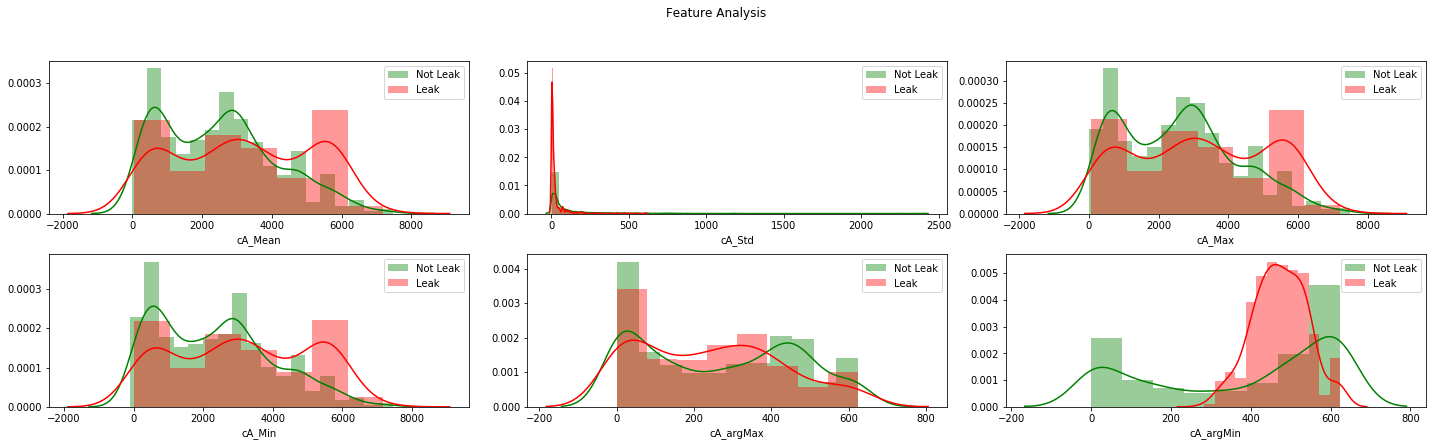

In [15]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in features_dist_cA.columns:
    plt.subplot(9, 3, j+1)
    j += 1
    sns.distplot(features_dist_cA[i][features_cA['Label']==0], color='g', label = 'Not Leak')
    sns.distplot(features_dist_cA[i][features_cA['Label']==1], color='r', label = 'Leak')
    plt.legend(loc='best')
fig.suptitle('Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [16]:
features_cD1 = get_SF_df(val_Wave_cD1,0,'cD1')
features_cD1

,File,PT,StartTime,Label,LeakTime,cD1_Mean,cD1_Std,cD1_Max,cD1_Min,cD1_argMax,cD1_argMin
0,2559,HDR3039,2019-11-06-13:32:24.20,0,7,0.007356,0.042165,0.129877,-0.043292,18.0,643.0
1,2714,GLT3023,2019-11-12-06:56:56.300,0,1168,-0.032785,0.026425,0.057723,-0.086585,609.0,304.0
2,766,HDR3039,2017-03-16-16:25:39.60,0,1206,0.022086,0.056866,0.461784,-0.028862,629.0,13.0
3,302,ESH3427,2017-01-26-11:53:42.530,0,1960,-0.019718,0.039626,0.115446,-0.129877,993.0,236.0
4,2024,ASK3746,2019-05-21-09:15:36.150,0,21,-0.008341,0.089083,0.216461,-0.202031,43.0,236.0
...,...,...,...,...,...,...,...,...,...,...,...
2235,735,HDR3037,2017-03-15-10:29:45.180,1,1772,0.000597,0.035515,0.202031,-0.187600,906.0,1070.0
2236,208,ASH3041,2017-01-16-07:11:58.180,0,2019,0.005928,0.055590,0.274184,-0.129877,1041.0,71.0
2237,1807,ASH3036,2018-07-12-08:16:56.460,0,1930,0.003734,0.014496,0.101015,-0.028862,980.0,1104.0
2238,186,ESH3437,2017-01-13-04:02:48.120,0,269,0.001164,0.052962,0.129877,-0.144308,148.0,995.0


In [17]:
features_dist_cD1 = features_cD1.drop(selected_columns, axis = 1)

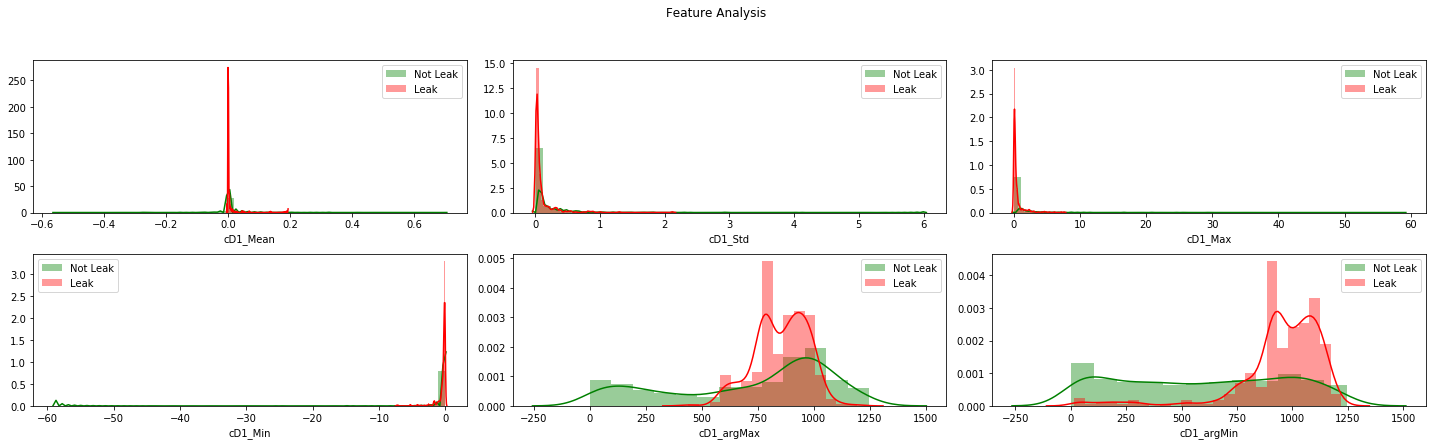

In [18]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in features_dist_cD1.columns:
    plt.subplot(9, 3, j+1)
    j += 1
    sns.distplot(features_dist_cD1[i][features_cD1['Label']==0], color='g', label = 'Not Leak')
    sns.distplot(features_dist_cD1[i][features_cD1['Label']==1], color='r', label = 'Leak')
    plt.legend(loc='best')
fig.suptitle('Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [19]:
features_cD2 = get_SF_df(val_Wave_cD2,0,'cD2')
features_cD2

,File,PT,StartTime,Label,LeakTime,cD2_Mean,cD2_Std,cD2_Max,cD2_Min,cD2_argMax,cD2_argMin
0,2559,HDR3039,2019-11-06-13:32:24.20,0,7,0.020234,0.118797,0.367347,-0.112245,18.0,310.0
1,2714,GLT3023,2019-11-12-06:56:56.300,0,1168,-0.093187,0.073618,0.153061,-0.224490,302.0,149.0
2,766,HDR3039,2017-03-16-16:25:39.60,0,1206,0.062306,0.158876,1.244898,-0.040816,314.0,186.0
3,302,ESH3427,2017-01-26-11:53:42.530,0,1960,-0.057323,0.108614,0.295918,-0.326531,496.0,30.0
4,2024,ASK3746,2019-05-21-09:15:36.150,0,21,-0.022172,0.247900,0.540816,-0.551020,22.0,110.0
...,...,...,...,...,...,...,...,...,...,...,...
2235,735,HDR3037,2017-03-15-10:29:45.180,1,1772,0.002228,0.097678,0.561224,-0.489796,453.0,534.0
2236,208,ASH3041,2017-01-16-07:11:58.180,0,2019,0.017077,0.153321,0.765306,-0.336735,520.0,36.0
2237,1807,ASH3036,2018-07-12-08:16:56.460,0,1930,0.010644,0.038612,0.255102,-0.081633,490.0,552.0
2238,186,ESH3437,2017-01-13-04:02:48.120,0,269,0.002753,0.147427,0.326531,-0.346939,74.0,12.0


In [20]:
features_dist_cD2 = features_cD2.drop(selected_columns, axis = 1)

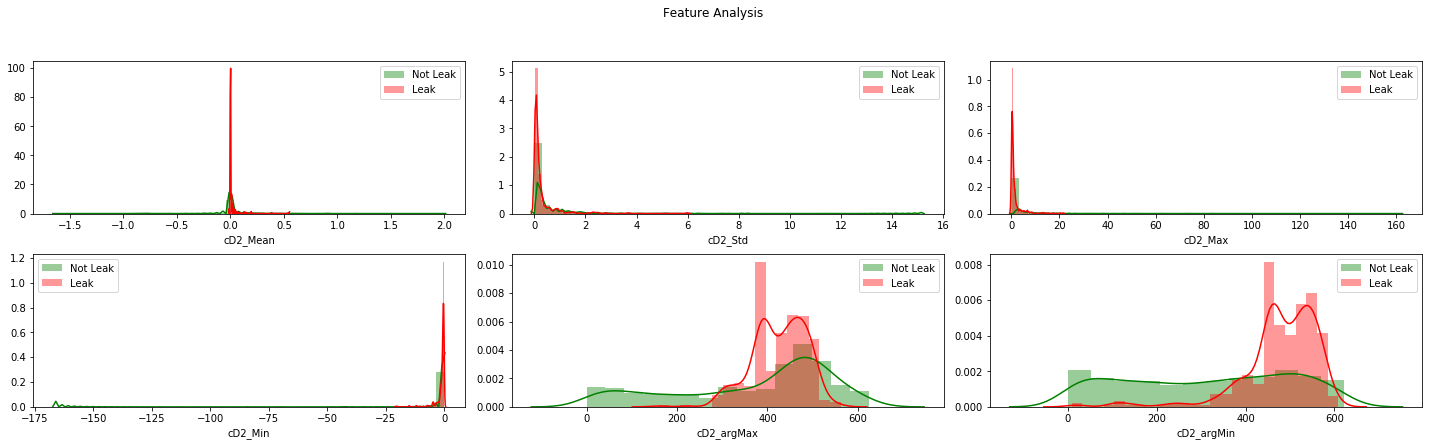

In [21]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in features_dist_cD2.columns:
    plt.subplot(9, 3, j+1)
    j += 1
    sns.distplot(features_dist_cD2[i][features_cD2['Label']==0], color='g', label = 'Not Leak')
    sns.distplot(features_dist_cD2[i][features_cD2['Label']==1], color='r', label = 'Leak')
    plt.legend(loc='best')
fig.suptitle('Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [22]:
All_wave_features = select_columns(df, selected_columns)
All_wave_features = pd.concat([All_wave_features, features_dist_cA,features_dist_cD1,features_dist_cD2], axis=1, sort=False)
All_wave_features.fillna(0)
All_wave_features.replace(np.inf, 0)
All_wave_features.replace(np.nan, 0, inplace=True)
All_wave_features.head()

,File,PT,StartTime,Label,LeakTime,cA_Mean,cA_Std,cA_Max,cA_Min,cA_argMax,...,cD1_Max,cD1_Min,cD1_argMax,cD1_argMin,cD2_Mean,cD2_Std,cD2_Max,cD2_Min,cD2_argMax,cD2_argMin
0,2559,HDR3039,2019-11-06-13:32:24.20,0,7,2207.013673,26.110918,2253.755102,2175.795918,421.0,...,0.129877,-0.043292,18.0,643.0,0.020234,0.118797,0.367347,-0.112245,18.0,310.0
1,2714,GLT3023,2019-11-12-06:56:56.300,0,1168,2645.890865,63.905768,2728.794898,2496.683163,624.0,...,0.057723,-0.086585,609.0,304.0,-0.093187,0.073618,0.153061,-0.224490,302.0,149.0
2,766,HDR3039,2017-03-16-16:25:39.60,0,1206,1633.245453,60.032271,1693.448980,1528.252041,284.0,...,0.461784,-0.028862,629.0,13.0,0.062306,0.158876,1.244898,-0.040816,314.0,186.0
3,302,ESH3427,2017-01-26-11:53:42.530,0,1960,2958.696367,53.344270,3029.336735,2826.541837,463.0,...,0.115446,-0.129877,993.0,236.0,-0.057323,0.108614,0.295918,-0.326531,496.0,30.0
4,2024,ASK3746,2019-05-21-09:15:36.150,0,21,4857.533094,51.014269,4918.071429,4771.979592,270.0,...,0.216461,-0.202031,43.0,236.0,-0.022172,0.247900,0.540816,-0.551020,22.0,110.0


In [23]:
All_wave_features.to_csv('all_wave_features_'+ds+'.csv', encoding='utf-8', index=False)

### FFT

Since our signal is sampled at a rate f_s of 50 Hz, the FFT will return the frequency spectrum up to a frequency of f_s / 2 = 25 Hz. The higher your sampling rate is, the higher the maximum frequency is FFT can calculate.

In [24]:
def get_fft_values(y_values, T, N, f_s):
    f_values = fftpack.fftfreq(len(y_values)) * f_s #np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(np.array(y_values))
    fft_values = 2.0/N * np.abs(fft_values_[0:N])
    return f_values, fft_values

The scipy.fftpack.fft function returns a vector of complex valued frequencies. Since they are complex valued, they will contain a real and an imaginary part. The real part of the complex value corresponds with the magnitude, and the imaginary part with the phase of the signal. Since we are only interested in the magnitude of the amplitudes, we use np.abs() to take the real part of the frequency spectrum.

The FFT of an input signal of N points, will return an vector of N points. The first half of this vector (N/2 points) contain the useful values  of the frequency spectrum from 0 Hz up to the Nyquist frequency of f_s / 2. The second half contains the complex conjugate and can be disregarded since it does not provide any useful information.

In [25]:
t_n = 1
N = 2500
T = 50
f_s = 50


fft_df = select_columns(df, selected_columns)

fft_val = df.drop(selected_columns,axis =1)

for index, row in fft_val.iterrows():
    data = row
    f_values, fft_values = get_fft_values(data, T, N, f_s)
    fft_val.iloc[index] = np.array(fft_values)
fft_df = pd.concat([select_columns(df, selected_columns), fft_val], axis=1)
fft_df

,File,PT,StartTime,Label,LeakTime,s0,s1,s2,s3,s4,...,s2490,s2491,s2492,s2493,s2494,s2495,s2496,s2497,s2498,s2499
0,2559,HDR3039,2019-11-06-13:32:24.20,0,7,2207.013673,15.551444,6.595804,5.790664,2.515845,...,0.942666,0.835070,1.017863,1.544396,1.729718,0.935890,2.515845,5.790664,6.595804,15.551444
1,2714,GLT3023,2019-11-12-06:56:56.300,0,1168,2645.890865,32.112525,22.119708,10.651081,10.282674,...,3.890757,3.990082,4.969678,4.990107,6.657157,6.854302,10.282674,10.651081,22.119708,32.112525
2,766,HDR3039,2017-03-16-16:25:39.60,0,1206,1633.245453,37.643795,7.553111,11.942097,3.726618,...,1.712012,3.871870,2.002307,5.041501,2.422845,7.268148,3.726618,11.942097,7.553111,37.643795
3,302,ESH3427,2017-01-26-11:53:42.530,0,1960,2958.696367,33.980583,10.107674,4.890744,5.407335,...,2.419741,2.518284,2.751907,2.945319,3.694489,4.888560,5.407335,4.890744,10.107674,33.980583
4,2024,ASK3746,2019-05-21-09:15:36.150,0,21,4857.533094,6.374852,33.910092,6.521697,6.802908,...,0.919953,1.403607,1.676170,0.842124,1.512465,2.314571,6.802908,6.521697,33.910092,6.374852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,735,HDR3037,2017-03-15-10:29:45.180,1,1772,3311.008310,3.637316,3.007381,2.075602,1.641470,...,0.329920,0.240667,0.038226,0.619130,1.097804,1.510031,1.641470,2.075602,3.007381,3.637316
2236,208,ASH3041,2017-01-16-07:11:58.180,0,2019,1056.041894,7.999684,6.199992,4.874216,2.490961,...,0.818805,1.285698,1.717264,1.639265,0.197409,0.694699,2.490961,4.874216,6.199992,7.999684
2237,1807,ASH3036,2018-07-12-08:16:56.460,0,1930,4895.242335,5.896924,4.054638,2.327071,0.730320,...,0.381238,0.451258,0.699942,0.767657,0.747147,0.429565,0.730320,2.327071,4.054638,5.896924
2238,186,ESH3437,2017-01-13-04:02:48.120,0,269,4737.886865,2.054424,1.814400,3.261536,9.070038,...,0.213783,0.280595,0.603672,1.030484,1.002465,1.747785,9.070038,3.261536,1.814400,2.054424


In [26]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(np.array(y_values))
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

In [27]:
waveletname = 'sym5'

DWT_df = select_columns(df, selected_columns)
val_df = df.drop(selected_columns,axis =1)

DWT_val = pd.DataFrame()

for index, row in val_df.iterrows():
    data = row
    for ii in range(5):
        (data, coeff_d) = pywt.dwt(data, waveletname)
    DWT_val = DWT_val.append(pd.Series(coeff_d), ignore_index = True)
    DWT_df = pd.concat([select_columns(df, selected_columns), DWT_val], axis=1)

In [28]:
features = get_SF_df(DWT_val,0,'DWT')
features

,File,PT,StartTime,Label,LeakTime,DWT_Mean,DWT_Std,DWT_Max,DWT_Min,DWT_argMax,DWT_argMin
0,2559,HDR3039,2019-11-06-13:32:24.20,0,7,-0.024877,0.304221,1.774319,-1.510984,0.0,3.0
1,2714,GLT3023,2019-11-12-06:56:56.300,0,1168,-0.005916,0.166698,0.808397,-0.929855,3.0,0.0
2,766,HDR3039,2017-03-16-16:25:39.60,0,1206,0.002636,0.672937,4.073451,-3.972469,42.0,41.0
3,302,ESH3427,2017-01-26-11:53:42.530,0,1960,0.011190,0.316769,1.285139,-1.526158,3.0,0.0
4,2024,ASK3746,2019-05-21-09:15:36.150,0,21,0.026093,0.401651,2.042612,-1.772004,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
2235,735,HDR3037,2017-03-15-10:29:45.180,1,1772,-0.088547,0.568378,2.447305,-2.656857,60.0,69.0
2236,208,ASH3041,2017-01-16-07:11:58.180,0,2019,0.031997,1.311530,2.649252,-4.861591,68.0,69.0
2237,1807,ASH3036,2018-07-12-08:16:56.460,0,1930,0.000694,0.227498,0.737013,-1.233148,67.0,66.0
2238,186,ESH3437,2017-01-13-04:02:48.120,0,269,0.006288,0.301693,1.545566,-1.799515,3.0,0.0


## Autocovariance and Autocorrelation

In [29]:
def autocovariance(data, N, k, Xs):
    autoCov = 0
    for i in np.arange(0, N-k):
        autoCov += ((data[i+k])-Xs)*(data[i]-Xs)
    return (1/(N-1))*autoCov

def autocorrelation(data, N, k, Xs):
    return autocovariance(data, N, k, Xs) / autocovariance(data, N, 0, Xs)

#print("Autocovariance:", autocovariance(data, N, k, Xs))
#print("Autocorrelation:", autocorrelation())

In [30]:
k = 50
N = 2500
val_df = df.drop(selected_columns,axis =1)

def get_SA_df(val_df,feature_df,N):
    for  index, row in val_df.iterrows():
        smp = np.array(row)
        Xs = smp.mean()
        
        feature_df.at[index,'autocov'] = autocovariance(smp, N, k, Xs)
        feature_df.at[index,'autocorr'] = autocorrelation(smp, N, k, Xs)
    return feature_df

In [31]:
features2 = get_SA_df(val_df,features,N)


C:\Users\anatk\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [32]:
features2

,File,PT,StartTime,Label,LeakTime,DWT_Mean,DWT_Std,DWT_Max,DWT_Min,DWT_argMax,DWT_argMin,autocov,autocorr
0,2559,HDR3039,2019-11-06-13:32:24.20,0,7,-0.024877,0.304221,1.774319,-1.510984,0.0,3.0,163.920874,0.961313
1,2714,GLT3023,2019-11-12-06:56:56.300,0,1168,-0.005916,0.166698,0.808397,-0.929855,3.0,0.0,947.389416,0.927540
2,766,HDR3039,2017-03-16-16:25:39.60,0,1206,0.002636,0.672937,4.073451,-3.972469,42.0,41.0,859.571434,0.953662
3,302,ESH3427,2017-01-26-11:53:42.530,0,1960,0.011190,0.316769,1.285139,-1.526158,3.0,0.0,667.645967,0.938111
4,2024,ASK3746,2019-05-21-09:15:36.150,0,21,0.026093,0.401651,2.042612,-1.772004,0.0,3.0,624.116561,0.958861
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,735,HDR3037,2017-03-15-10:29:45.180,1,1772,-0.088547,0.568378,2.447305,-2.656857,60.0,69.0,15.490775,0.885023
2236,208,ASH3041,2017-01-16-07:11:58.180,0,2019,0.031997,1.311530,2.649252,-4.861591,68.0,69.0,67.024802,0.913254
2237,1807,ASH3036,2018-07-12-08:16:56.460,0,1930,0.000694,0.227498,0.737013,-1.233148,67.0,66.0,29.100476,0.950672
2238,186,ESH3437,2017-01-13-04:02:48.120,0,269,0.006288,0.301693,1.545566,-1.799515,3.0,0.0,46.453301,0.870600


In [33]:
features_dist = features2.drop(selected_columns, axis = 1)

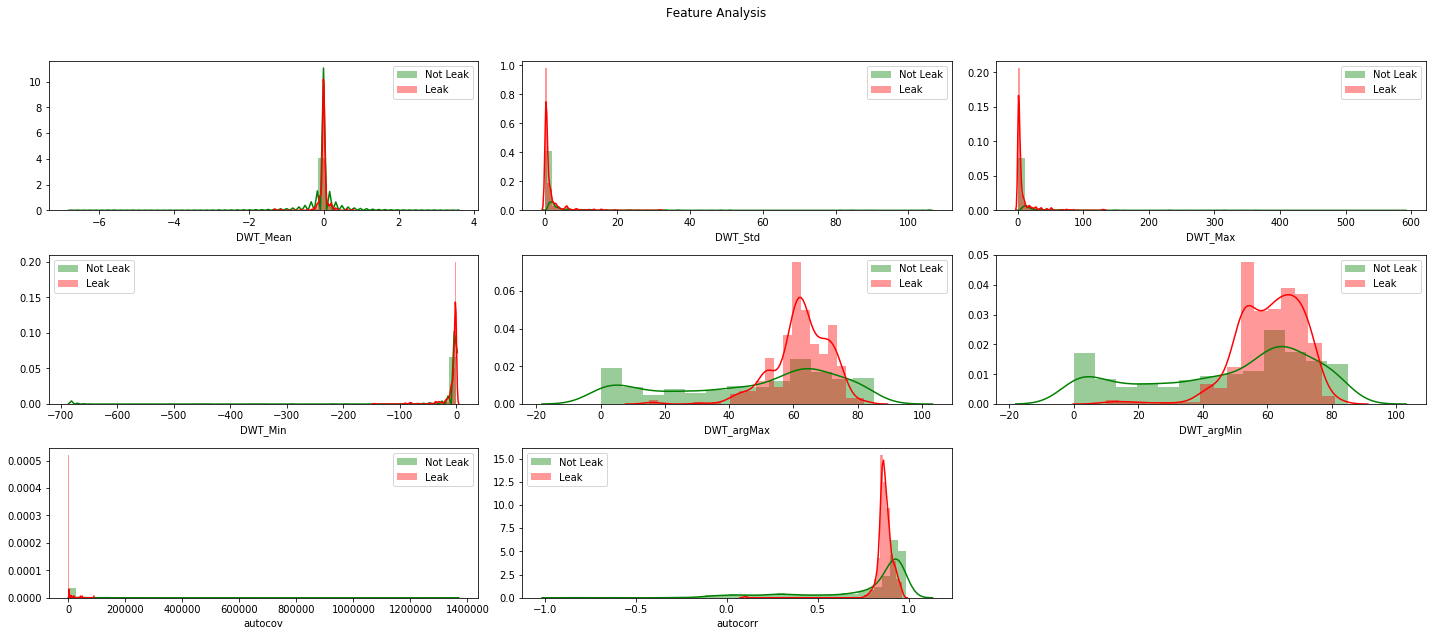

In [34]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in features_dist.columns:
    plt.subplot(9, 3, j+1)
    j += 1
    sns.distplot(features_dist[i][features['Label']==0], color='g', label = 'Not Leak')
    sns.distplot(features_dist[i][features['Label']==1], color='r', label = 'Leak')
    plt.legend(loc='best')
fig.suptitle('Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [35]:
features2.to_csv('FD_features_'+ds+'.csv', encoding='utf-8', index=False)
